In [140]:
import plotly.express as px
import imageio
import numpy as np
import cv2
import torch
import json
import matplotlib.pyplot as plt
from lines_and_field_detector import LineDetector
from shapely.geometry import LineString, Polygon


In [141]:
template_path = './data/template.png'
json_path = './data/lines_coordinates.json'
image = ".//example.png"
image_arr = cv2.imread(image)
template = cv2.imread(template_path)
print(template.shape)
print(image_arr.shape)
line_detector = LineDetector(image_array=image_arr)
line_detector.get_orig_optim_homography()
h_inv = line_detector.homography_inv.detach().numpy()

(680, 1050, 3)
(720, 1280, 3)
---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for loss_surface
From: /home/skocznapanda/programming/BSc-soccer-annotator/automatic_models/lines_and_field_detection/out/pretrained_loss_surface/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /home/skocznapanda/programming/BSc-soccer-annotator/automatic_models

  0%|          | 0/30 [00:00<?, ?it/s]/home/skocznapanda/programming/BSc-soccer-annotator/venv/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


## FUNCTIONS

In [124]:
def check_point_within_boundaries(point: np.ndarray,
                                  boundaries: tuple):
    """
    Check if point lies inside an image of shape boundaries[0] x boundaries[1]
    More precisely, check if point[0] is in [0. boundaries[0], point[1] is in [0, boundaries[1]
    :param point: np.array ([x, y])
    :param boundaries; tuple (x_buondary, y_buondary):
    :returns: True if point inside, False otherwise
    """
    return (point[0] > 0) and (point[0] <= boundaries[0]) and (point[1] >= 0) and (point[1] < boundaries[1])
def map_template_point_to_frame(frame_point: np.ndarray,
                                H_inv: np.ndarray,
                                out_shape: tuple,
                                template_shape = (1050, 680)):
    """
    Map frame point from pitch template to frame.
    :param frame_point: (x, y) point from template
    """
    assert isinstance(frame_point, np.ndarray)

    # moving frame_point to [-0.5, 0.5] range
    x = frame_point[0] / template_shape[0] - 0.5
    y = frame_point[1] / template_shape[1] - 0.5
    xy = np.array([x, y, 1])
    xy_warped = np.matmul(H_inv, xy)[0]
    xy_warped, z_warped = xy_warped[0:2], xy_warped[2]
    xy_warped = 2 * xy_warped / (z_warped + 1e-8)
    x_warped = (xy_warped[0]  * 0.5 + 0.5) * out_shape[0]
    y_warped = (xy_warped[1]  * 0.5 + 0.5) * out_shape[1]
    return np.array([x_warped, y_warped])


def map_line_to_frame(line_point_1: np.ndarray,
                      line_point_2: np.ndarray,
                      H_inv: np.ndarray,
                      out_shape: tuple,
                      template_shape = (1050, 680)):
    point_1_new = map_template_point_to_frame(line_point_1,
                                              H_inv=H_inv,
                                              out_shape=out_shape,
                                              template_shape=template_shape)
    point_2_new = map_template_point_to_frame(line_point_2,
                                              H_inv=H_inv,
                                              out_shape=out_shape,
                                              template_shape=template_shape)
    flag_1, flag_2 = check_point_within_boundaries(point_1_new, out_shape), check_point_within_boundaries(point_2_new, out_shape)
    if flag_1 and flag_2:
        # both extremities are mapped inside frame so they define line on frame
        return np.array([point_1_new, point_2_new])
    else:
        line = LineString([point_1_new, point_2_new])
        polygon = Polygon([(0,0), (out_shape[0], 0), (out_shape[0], out_shape[1]), (0, out_shape[1])])
        intersection_points = np.array(polygon.intersection(line).coords.xy).transpose()
        return intersection_points if intersection_points.size > 0 else None

def get_field(H_inv: np.ndarray,
              out_shape: tuple,
              template_shape: tuple = (1050, 680)):
    points_template = np.array([[0, 0], [template_shape[0], 0], [template_shape[0], template_shape[1]], [0, template_shape[1]]])
    polygon_mapped = Polygon(np.apply_along_axis(lambda k: map_template_point_to_frame(k,
                                                                              H_inv=H_inv,
                                                                              out_shape=out_shape,
                                                                              template_shape=template_shape), axis=1, arr=points_template))
    polygon_frame = Polygon([[0,0], [out_shape[0], 0], [out_shape[0], out_shape[1]], [0, out_shape[1]]])
    coords = np.array(polygon_frame.intersection(polygon_mapped).exterior.coords.xy).transpose()
    return coords


## TESTING GETTING FIELD

In [125]:
get_field(h_inv, (1280, 720), (1050, 680))

array([[1280.        ,  277.84671037],
       [ 793.75113268,  158.86767677],
       [   0.        ,  201.79980121],
       [   0.        ,  720.        ],
       [ 817.62666141,  720.        ],
       [1280.        ,  649.47849924],
       [1280.        ,  277.84671037]])

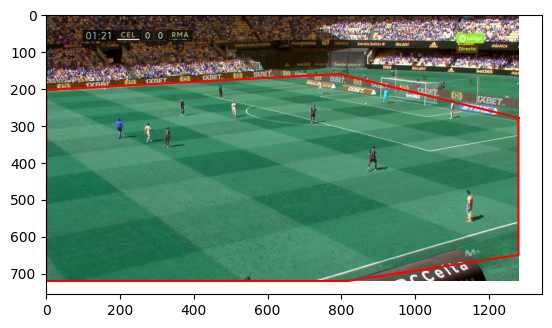

In [126]:
coords = get_field(h_inv, (1280, 720), (1050, 680))
plt.imshow(image_arr)
plt.plot(coords[:,0], coords[:,1], 'r')

## TESTING LINES

In [139]:
points_up = map_line_to_frame(line_point_1=np.array([1050, 0]),
                              line_point_2=np.array([1050, 680]),
                              H_inv=h_inv,
                              out_shape=(1280, 720),
                              template_shape=(1050, 680))
points_up


array([[ 793.75113268,  158.86767677],
       [1280.        ,  277.84671037]])

[[  0.         201.79980121]
 [793.75113268 158.86767677]]


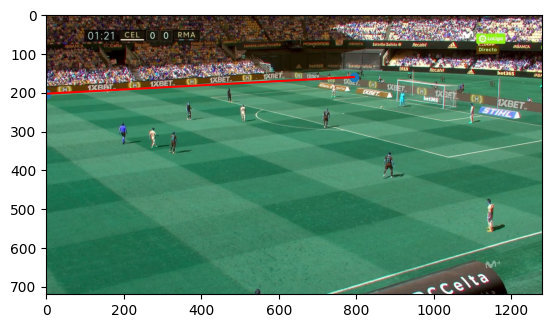

In [127]:
points_up = map_line_to_frame(line_point_1=np.array([0, 0]),
                  line_point_2=np.array([1050,0]),
                  H_inv=h_inv,
                  out_shape=(1280, 720),
                  template_shape=(1050, 680))
plt.imshow(image_arr)
plt.scatter(points_up[:,0], points_up[:,1])
plt.plot(points_up[:,0], points_up[:,1], 'r')
plt.show()

In [134]:
points_up = map_line_to_frame(line_point_1=np.array([0, 0]),
                  line_point_2=np.array([0,680]),
                  H_inv=h_inv,
                  out_shape=(1280, 720),
                  template_shape=(1050, 680))
points_up == None


True

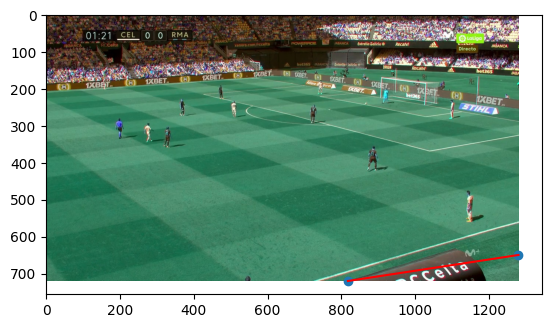

In [133]:
points_up = map_line_to_frame(line_point_1=np.array([0, 680]),
                  line_point_2=np.array([1050,680]),
                  H_inv=h_inv,
                  out_shape=(1280, 720),
                  template_shape=(1050, 680))

plt.imshow(image_arr)
plt.scatter(points_up[:,0], points_up[:,1])
plt.plot(points_up[:,0], points_up[:,1], 'r')

## TESTING MAP_TEMPLATE_POINT_TO_FRAME

In [137]:
x1 = map_template_point_to_frame(frame_point=np.array([5, 674]),
                            H_inv=line_detector.homography_inv.detach().numpy(),
                            out_shape=(1280, 720))
x2 = map_template_point_to_frame(frame_point=np.array([1044, 674]),
                                 H_inv=line_detector.homography_inv.detach().numpy(),
                                 out_shape=(1280, 720))
x1, x2

(array([-10694.17112613,   2434.97821698]),
 array([2170.98848004,  503.25407156]))

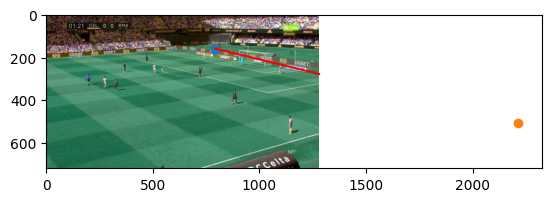

In [161]:
plt.imshow(image_arr)
plt.scatter(points_up[0][0], points_up[0][1])
plt.scatter(points_up[1][0], points_up[1][1])
plt.plot(np.array([1280, 793]), np.array([277, 158]), 'r')
plt.show()